1. Установка Adversarial Robustness Twoblox (ART) и matplotlib

In [4]:
!pip3 install adversarial-robustness-toolbox matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 156.2 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 390.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 136.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 88.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 131.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 191.6 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip


2. Импорт необходимых библиотек

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor,PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

3. Загрузка датасета MNIST

In [6]:
# Набор данных MNIST
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Cлучайная выборка
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

4. Предобработка данных

In [7]:
# Отравление обучающей выборки
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Перемешивание данных
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

5. Функция create_model() для создания последовательной модели из 9 слоев

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

def create_model():
    model = Sequential() # Установка архитектуры модели
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) # 1 свёрточный слой
    model.add(Conv2D(64, (3, 3), activation='relu')) # 2 свёрточный слой
    model.add(MaxPooling2D(pool_size=(2, 2))) # Слой пулинга
    model.add(Dropout(0.25)) # 1 дропаут слой
    model.add(Flatten()) # Слой выравнивания
    model.add(Dense(128, activation='relu')) # 1 полносвязный слой
    model.add(Dropout(0.25)) # 2 дропаут слой
    model.add(Dense(10, activation='softmax')) # 2 полносвязный слой
    # Компиляция
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Возврат модели
    return model

6. Создание атаки

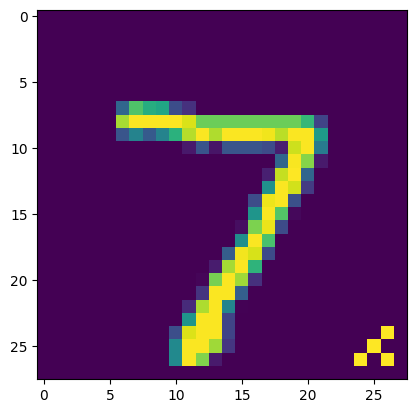

In [13]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

7. Определение целевого класса атаки

In [14]:
targets = to_categorical([9], 10)[0]

8. Создание модели

In [15]:
model = KerasClassifier(create_model())
proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]2024-01-28 20:04:52.914723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-28 20:04:52.948450: W tensorflow/c/c_api.cc:305] Operation '{name:'total_1/Assign' id:407 op device:{requested: '', assigned: ''} def:{{{node total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_1, total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 20:04:53.344668: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_3/Softmax' id:402 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after

9. Исполнение атаки

In [16]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor,
                                           proxy_classifier=proxy.get_classifier(),
                                           target=targets,
                                           pp_poison=percent_poison,
                                           norm=2,
                                           eps=5,
                                           eps_step=0.1,
                                           max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


10. Создание отравленных примеров данных

1007
Label: 9


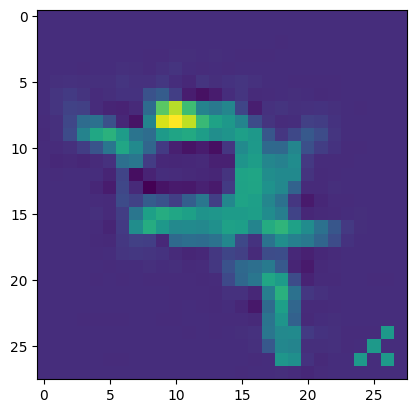

In [17]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
idx = 0
plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

11. Обучение модели на отравленных данных

In [18]:
model.fit(pdata, plabels, nb_epochs=10)

2024-01-28 20:17:35.870551: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:197 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 20:17:35.910139: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense/bias/m/Assign' id:993 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense/bias/m, training_2/Adam/dense/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

12. Тестирование на чистой модели

2024-01-28 20:19:06.709561: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:121 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Точность чистого тестового набора: 98.05%


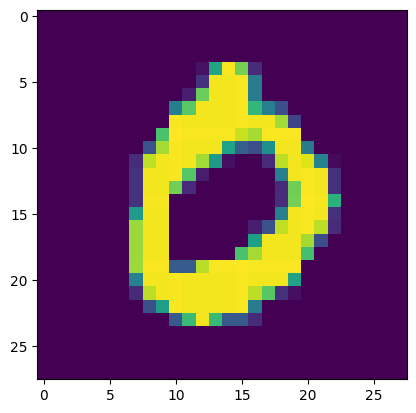

Прогноз: 0


In [19]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]
clean_acc = clean_correct / clean_total

print("\nТочность чистого тестового набора: %.2f%%" % (clean_acc * 100))

# Отображение картинки, класса, и предсказания для чистого примера
# чтобы показать как отравленная модель классифицирует чистый пример
c = 0 # Класс
i = 0 # Изображение
c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # индекс изображения в массиве чистых примеров
plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Прогноз: " + str(clean_preds[c_idx]))

13. Получение результатов атаки на модель


Точность отравленного набора: 3.16%


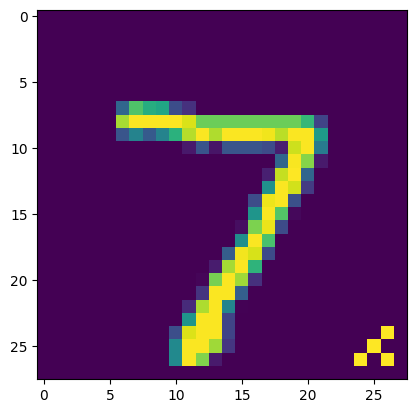

Прогноз: 9


In [20]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target],
axis=1))
poison_total = poison_preds.shape[0]
poison_acc = poison_correct / poison_total

print("\nТочность отравленного набора: %.2f%%" % (poison_acc * 100))

c = 0 # индекс для отображения
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Прогноз: " + str(poison_preds[c]))